#### The following analysis explores the relationship between the plot keywords between the following set of movie
1. IMBD top 250
2. Top 250 highest grossing movies
3. Top 250 movies with the highest budget

#### The aim is to see what kind of movies are liked by the audience, critics and producers and whether or not there is an overlap

In [38]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

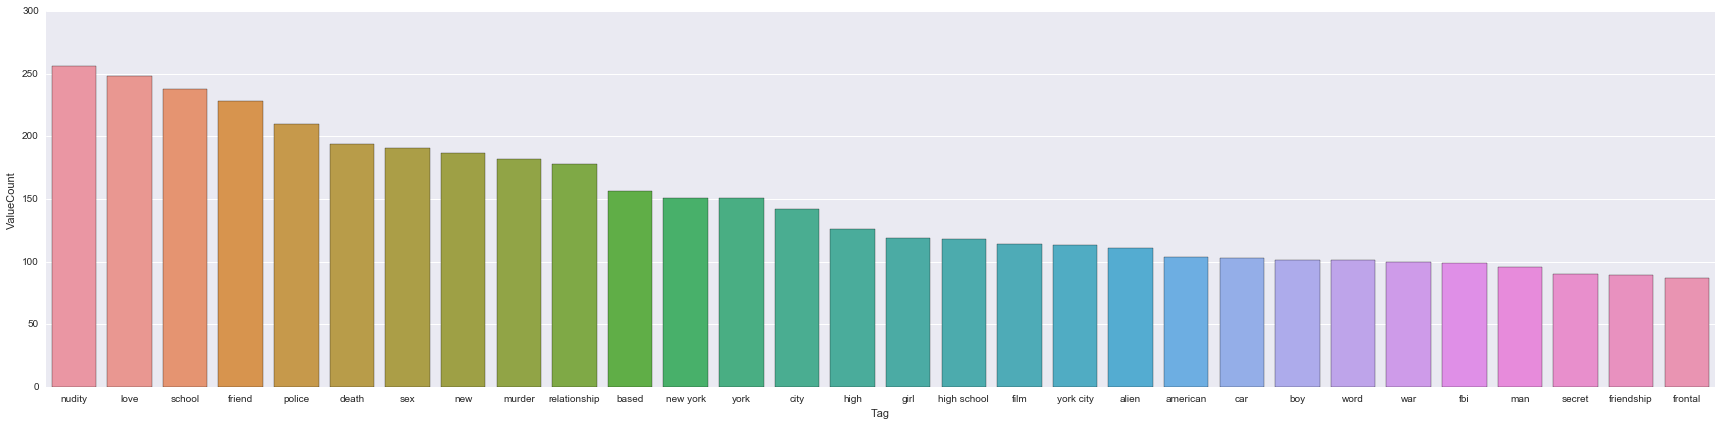

In [39]:
df = pd.read_csv('data/movie_metadata.csv')
df = df[df['num_voted_users'] > 100][['plot_keywords', 'gross', 'budget','duration','imdb_score', 'movie_title']]
# Split the plot_keyword string based on '|' and add an row for each string that is returned
tags = df['plot_keywords'].copy().str.split('|').apply(pd.Series, 1).stack()
tags.index = tags.index.droplevel(-1)
tags.index
tags.name = 'tags'
df = df.join(tags)
count_vect = CountVectorizer(ngram_range=(1,2), stop_words ={'and', 'in', 'of', 'the', 'on','to', 'title','reference',\
                                                             'female','male','by'})
# Calculated only term frequency.
X_train_counts = count_vect.fit_transform(df.tags.dropna())
MaxFeatureValues = X_train_counts.todense().sum(axis = 0).tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(MaxFeatureValues)), MaxFeatureValues) if pair[1] > 0]
TopTags = sorted(phrase_scores, key=lambda t: t[1] * -1)[:30]
ind = [x[0] for x in TopTags]
topValues = [x[1] for x in TopTags]
featurelist = count_vect.get_feature_names()
TopTagsNames = [featurelist[j] for j in ind]
TopTagsDf = pd.DataFrame({'Tag':TopTagsNames,'ValueCount':topValues})
ax = sns.factorplot(x="Tag", y="ValueCount", data = TopTagsDf, kind="bar", size=6, aspect=4)

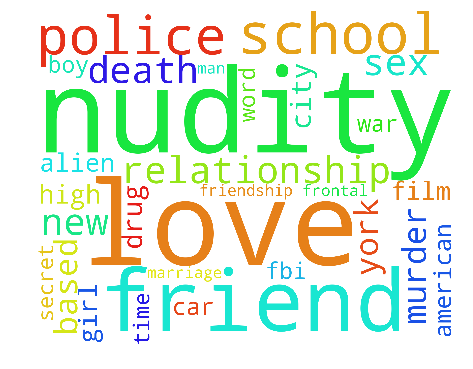

In [56]:
# Creating a word cloud of the 30 words
sWords = {'and', 'in', 'of', 'the', 'on','to', 'title','reference','female','male','by'}
tagsString = " ".join(df.tags.dropna().tolist())
wordcloud = WordCloud(stopwords=sWords,
                          background_color='white',
                          max_words = 30,
                          width=2500,
                          height=2000
                         ).generate(tagsString)
plt.imshow(wordcloud)
plt.rcParams["figure.figsize"] = [8, 6]
plt.axis('off')
plt.show()

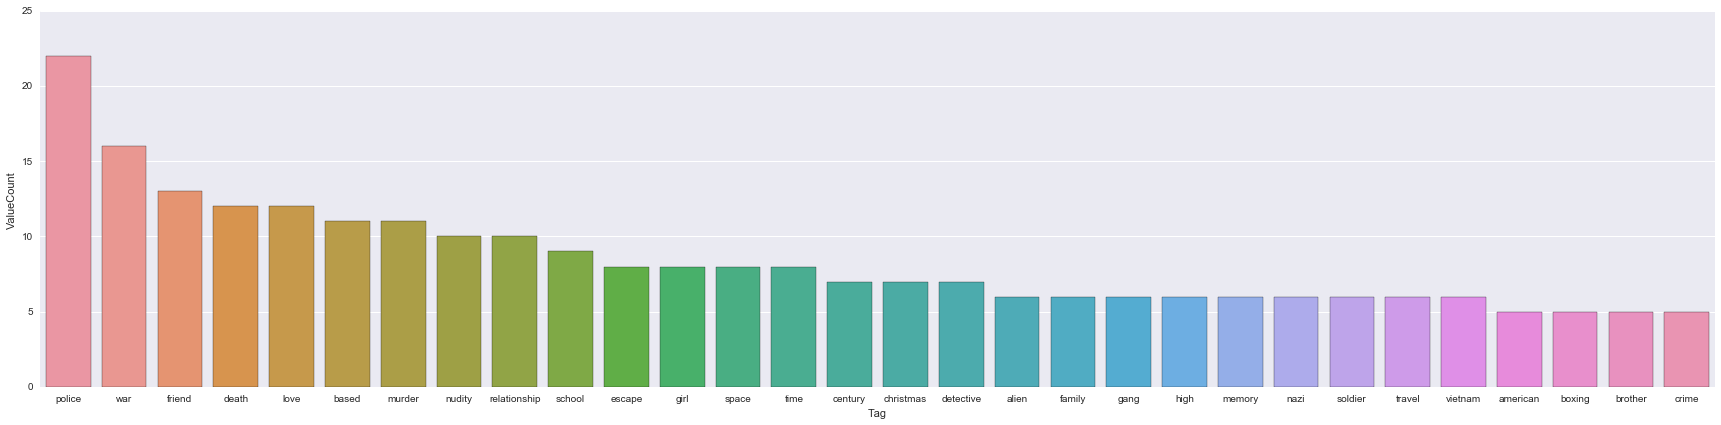

In [41]:
Top250 = df[['movie_title','imdb_score']].drop_duplicates().sort_values('imdb_score').tail(250)
Top250IMDBScore = Top250.join(df[['tags']])
X_train_counts = count_vect.fit_transform(Top250IMDBScore.tags.dropna())
MaxFeatureValues = X_train_counts.todense().sum(axis = 0).tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(MaxFeatureValues)), MaxFeatureValues) if pair[1] > 0]
TopTags = sorted(phrase_scores, key=lambda t: t[1] * -1)[:30]
ind = [x[0] for x in TopTags]
featurelist = count_vect.get_feature_names()
topValuesIMDB250 = [x[1] for x in TopTags]
TopTagsNamesIMDB250 = [featurelist[j] for j in ind]
ay = sns.factorplot(x="Tag", y="ValueCount", data = pd.DataFrame({'Tag':TopTagsNamesIMDB250,
                                                                  'ValueCount':topValuesIMDB250}),kind="bar",
                    size=6, aspect=4)

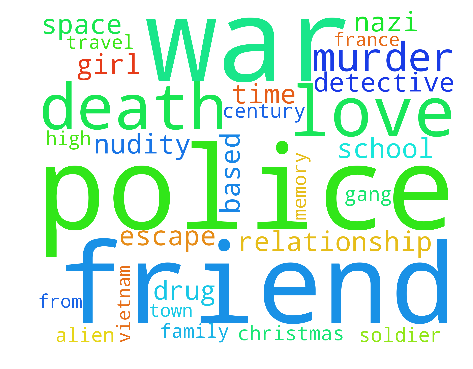

In [63]:
# Creating a word cloud of the top 30 words
tagsString = " ".join(Top250IMDBScore.tags.dropna().tolist())
wordcloudTop250IMDBScore = WordCloud(stopwords=sWords,
                          background_color='white',
                          max_words = 30,
                          width=2500,
                          height=2000
                         ).generate(tagsString)
plt.rcParams["figure.figsize"] = [10, 6]
plt.imshow(wordcloudTop250IMDBScore)
plt.axis('off')
plt.show()

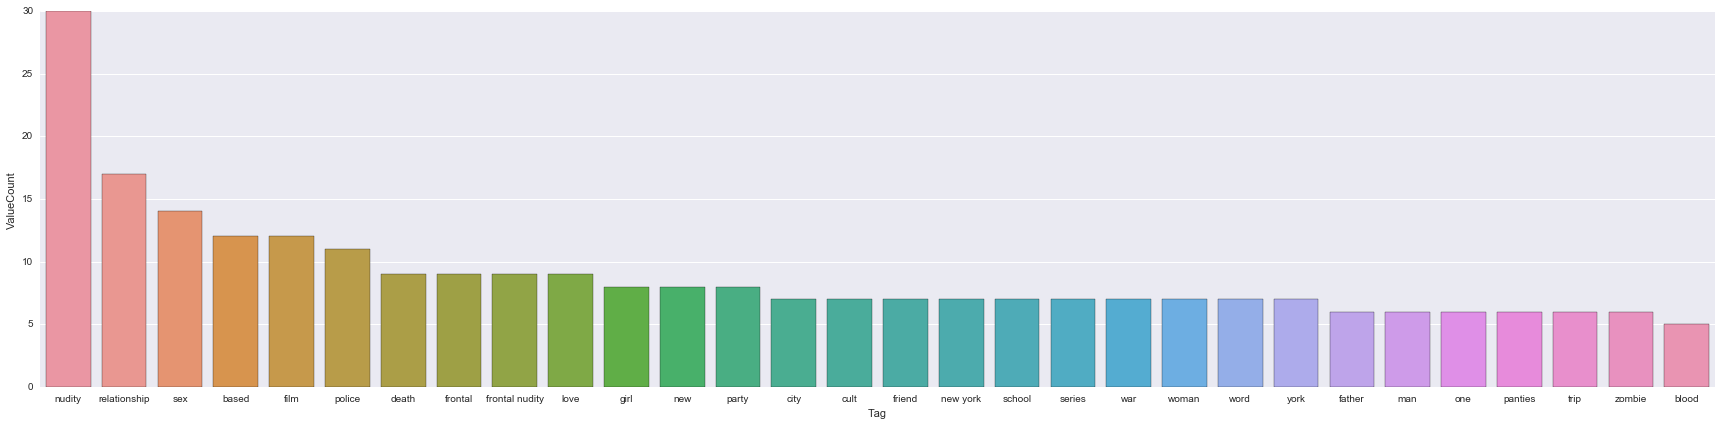

In [43]:
Top250 = df[['movie_title','gross']].drop_duplicates().sort_values('gross').tail(250)
Top250Grossing = Top250.join(df[['tags']])
X_train_counts = count_vect.fit_transform(Top250Grossing.tags.dropna())
MaxFeatureValues = X_train_counts.todense().sum(axis = 0).tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(MaxFeatureValues)), MaxFeatureValues) if pair[1] > 0]
TopTags = sorted(phrase_scores, key=lambda t: t[1] * -1)[:30]
ind = [x[0] for x in TopTags]
featurelist = count_vect.get_feature_names()
topValues250Grossing = [x[1] for x in TopTags]
TopTagsNames250Grossing = [featurelist[j] for j in ind]
ay = sns.factorplot(x="Tag", y="ValueCount", data = pd.DataFrame({'Tag':TopTagsNames250Grossing,
                                                                  'ValueCount':topValues250Grossing}),kind="bar",
                    size=6, aspect=4)

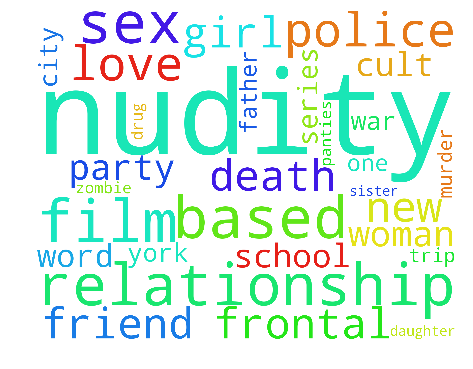

In [62]:
# Creating a word cloud of the top 30 words
tagsString = " ".join(Top250Grossing.tags.dropna().tolist())
wordcloudTop250Grossing = WordCloud(stopwords=sWords,
                          background_color='white',
                          max_words = 30,
                          width=2500,
                          height=2000
                         ).generate(tagsString)
plt.rcParams["figure.figsize"] = [10, 6]
plt.imshow(wordcloudTop250Grossing)
plt.axis('off')
plt.show()

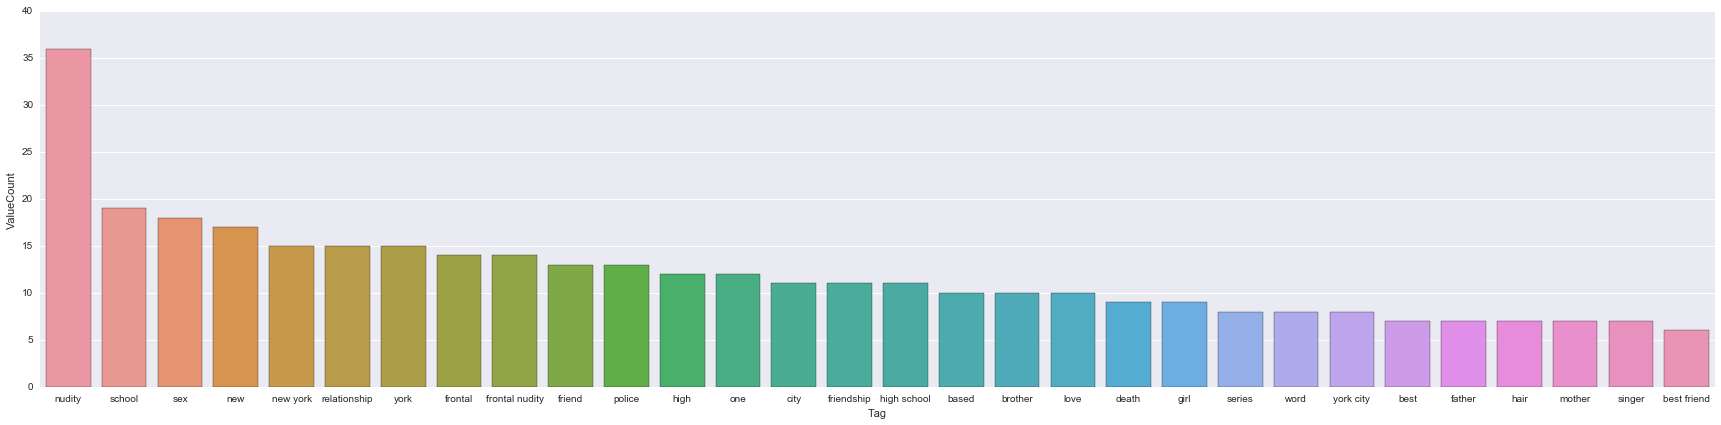

In [44]:
Top250 = df[['movie_title','budget']].drop_duplicates().sort_values('budget').tail(250)
Top250Budget = Top250.join(df[['tags']])
X_train_counts = count_vect.fit_transform(Top250Budget.tags.dropna())
MaxFeatureValues = X_train_counts.todense().sum(axis = 0).tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(MaxFeatureValues)), MaxFeatureValues) if pair[1] > 0]
TopTags = sorted(phrase_scores, key=lambda t: t[1] * -1)[:30]
ind = [x[0] for x in TopTags]
featurelist = count_vect.get_feature_names()
topValues250Budget = [x[1] for x in TopTags]
TopTagsNames250Budget = [featurelist[j] for j in ind]
ay = sns.factorplot(x="Tag", y="ValueCount", data = pd.DataFrame({'Tag':TopTagsNames250Budget,
                                                                  'ValueCount':topValues250Budget}),kind="bar",
                    size=6, aspect=4)

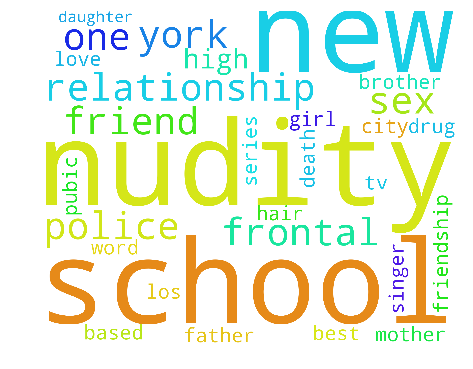

In [64]:
# Creating a word cloud of the top 30 words
tagsString = " ".join(Top250Budget.tags.dropna().tolist())
wordcloudTop250BudgetString = WordCloud(stopwords=sWords,
                          background_color='white',
                          max_words = 30,
                          width=2500,
                          height=2000
                         ).generate(tagsString)
plt.rcParams["figure.figsize"] = [10, 6]
plt.imshow(wordcloudTop250BudgetString)
plt.axis('off')
plt.show()

Nudity and sex seems to be a good selling point for blockbusters and the producers know it too as it is equally common in big budget movies. Apart from that New York is pretty popular in movies as it comes in all the lists except for the IMDB top 250. 

Finally people like to go to watch movies to which they can relate to that is why i guess sex, nudity and relationship are the top 3 keywords in the higest grossing movies and producers and cinema houses seems to know their audience as well. The highest rated films however are of a different class as they seem to tackle deeper and some times fictonal issue.

P.S. - I was not able find a way to properly represent the fact on graph, if you have an idea or method please leave a comment. 

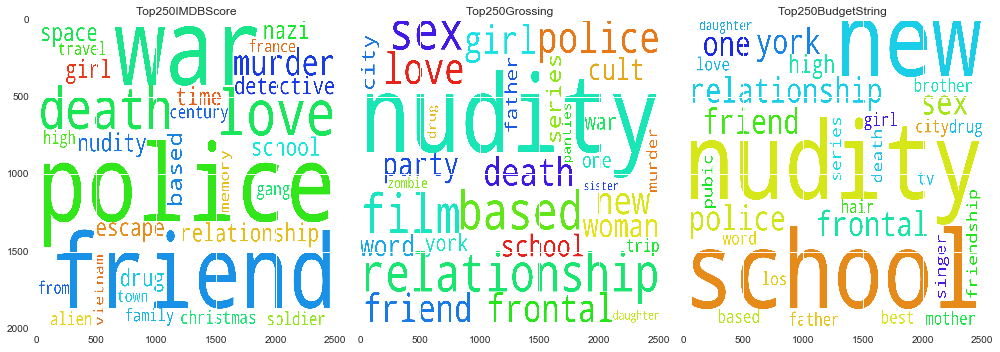

In [84]:
# Lets also compare the 3 word clouds side by side

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(14, 5))
ax1.imshow(wordcloudTop250IMDBScore, aspect='auto')
ax1.set_title('Top250IMDBScore')
ax2.imshow(wordcloudTop250Grossing, aspect='auto')
ax2.set_title('Top250Grossing')
ax3.imshow(wordcloudTop250BudgetString, aspect='auto')
ax3.set_title('Top250BudgetString')
plt.tight_layout()

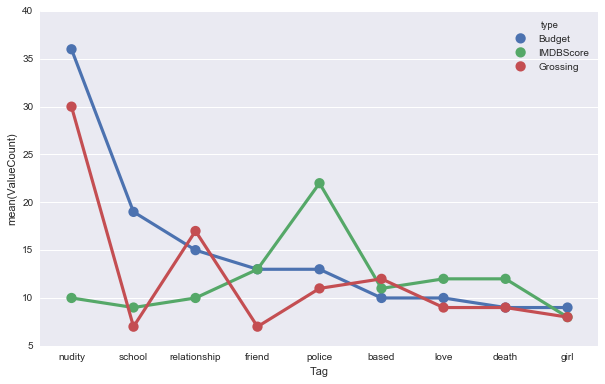

In [85]:
commonTags = list(set(TopTagsNames250Budget).intersection(TopTagsNames250Grossing).intersection(TopTagsNamesIMDB250))

Top250Budget = pd.DataFrame({'Tag':TopTagsNames250Budget,'ValueCount':topValues250Budget})
Top250IMDB = pd.DataFrame({'Tag':TopTagsNamesIMDB250,'ValueCount':topValuesIMDB250})
Top250Gross = pd.DataFrame({'Tag':TopTagsNames250Grossing,'ValueCount':topValues250Grossing})

Top250BudgetFiltered = Top250Budget.copy()[Top250Budget['Tag'].isin(commonTags)]
Top250BudgetFiltered['type'] = 'Budget'
Top250IMDBFiltered = Top250IMDB.copy()[Top250IMDB['Tag'].isin(commonTags)]
Top250IMDBFiltered['type'] = 'IMDBScore'
Top250GrossFiltered = Top250Gross.copy()[Top250Gross['Tag'].isin(commonTags)]
Top250GrossFiltered['type'] = 'Grossing'
Top250BudgetFiltered = Top250BudgetFiltered.append(Top250IMDBFiltered).append(Top250GrossFiltered)

plt.rcParams["figure.figsize"] = (10, 6)
sns.pointplot(x="Tag", y="ValueCount", hue="type", data=Top250BudgetFiltered)